In [1]:
import numpy as np
import pandas as pd
import requests as req
import emcee
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy.optimize import minimize
%matplotlib inline
np.random.seed(42)

In [2]:
print(np.__version__)
print(pd.__version__)
print(req.__version__)
print(emcee.__version__)
print(matplotlib.__version__)
print(scipy.__version__)

1.18.1
1.0.1
2.22.0
2.2.1
3.1.3
1.4.1


(2, 2350)


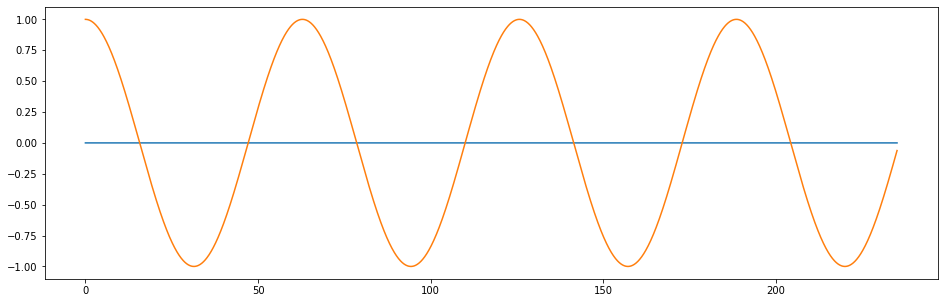

In [44]:
# create artificial training data for tests
np.random.seed(42)

eps0 = np.random.normal(0, 0.1, size=2350)
eps1 = np.random.normal(0, 0.1, size=2350)
eps2 = np.random.normal(0, 0.05, size=2350)
eps3 = np.random.normal(0, 0.15, size=2350)

x = np.linspace(0, 235, 2350)
y0 = np.zeros(len(x)) #+ eps0
y1 = np.cos(0.1*x) #+ eps1
#y2 = np.cos(0.4*x) + eps2
#y2 = -0.02*x +1.5 #+ eps2
#y3 = np.cos(0.2*x) #+ eps3
D = 2

#all_training_data2_raw = np.stack([y0, y1, y2, y3], axis=0)
#all_training_data2_raw = np.stack([y0, y1, y2], axis=0)
all_training_data2_raw = np.stack([y0, y1], axis=0)
print(np.shape(all_training_data2_raw))

plt.figure(figsize=(16, 5))
plt.plot(x, y0)
plt.plot(x, y1)
#plt.plot(x, y2)
#plt.plot(x, y3)
plt.show();

In [50]:
# always combine ten datapoints

covariances_emp = []
mus_emp = []

counter = 0
mean_ = np.zeros(D)
cov_ = np.zeros((D,D))

for z_i in all_training_data2_raw.T:
    
    #mu_i = z_i.mean()
    mu_i=0
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    
    cov_ += x_i
    mean_ += z_i
    counter += 1
    
    if counter == 10:
        
        mus_emp.append(mean_ /10)
        covariances_emp.append(cov_/10)
        #reset
        counter = 0
        mean_ = np.zeros(D)
        cov_ = np.zeros((D,D))
    
covariances_emp = np.array(covariances_emp)
mus_emp = np.array(mus_emp)
print(np.shape(covariances_emp))
print(np.shape(mus_emp))

(235, 2, 2)
(235, 2)


(2, 60)


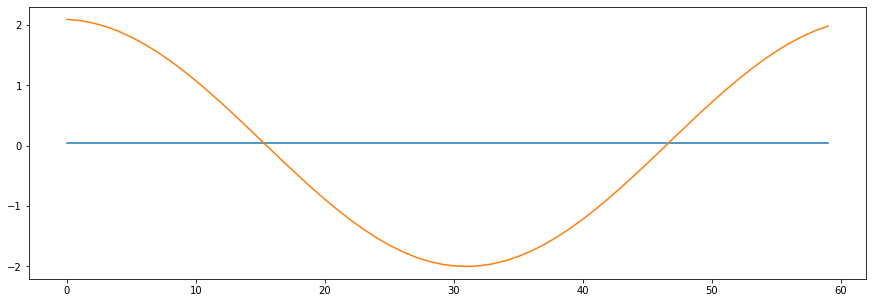

In [51]:
# playing around

N_train = 60

train_data = mus_emp.T[:, 0:N_train] #235
train_data = train_data - train_data.mean() #center the data
train_data = train_data / np.std(train_data) #why are we doing this?
train_var = np.var(train_data)
print(np.shape(train_data))

plt.figure(figsize=(15, 5))
for i in range(np.shape(train_data)[0]):
    plt.plot(train_data[i, :])
    
plt.show();

In [52]:
covariances_emp_train = covariances_emp[0:N_train, :, :]

In [53]:
print(np.shape(covariances_emp_train))

cov_emp_0 = covariances_emp_train[:,0,0]
cov_emp_1 = covariances_emp_train[:,0,1]
#cov_emp_2 = covariances_emp_train[:,0,2]
#cov_emp_3 = covariances_emp_train[:,0,3]


(60, 2, 2)


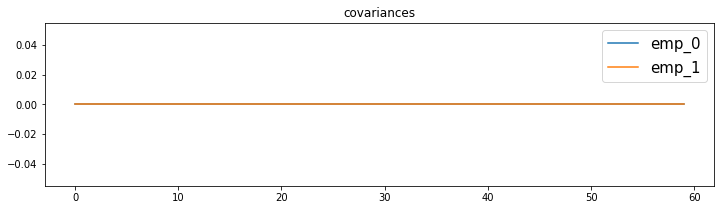

In [54]:
plt.figure(figsize=(12, 3))
legend_size = 15

plt.plot(cov_emp_0, label="emp_0")
plt.plot(cov_emp_1, label="emp_1")
#plt.plot(cov_emp_2, label="emp_2")
#plt.plot(cov_emp_3, label="emp_3")
plt.title("covariances")

plt.legend(prop={'size': legend_size});
plt.show();

In [61]:
# compute the outer products of the mus
covariances_emp_outer_train = []

for z_i in train_data.T:
    
    #mu_i = z_i.mean()
    mu_i = 0
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    
    covariances_emp_outer_train.append(x_i)
    
covariances_emp_outer_train = np.array(covariances_emp_outer_train)
print(np.shape(covariances_emp_outer_train))

(60, 2, 2)


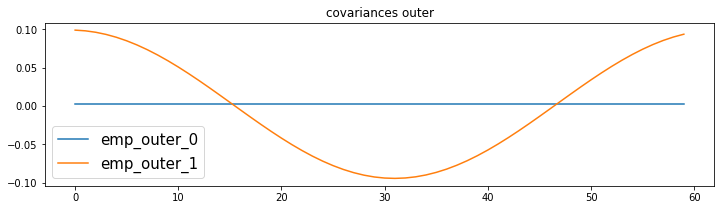

In [62]:
#define and plot outer products of mus

cov_emp_outer_0 = covariances_emp_outer_train[:,0,0]
cov_emp_outer_1 = covariances_emp_outer_train[:,0,1]
#cov_emp_outer_2 = covariances_emp_outer_train[:,0,2]
#cov_emp_outer_3 = covariances_emp_outer_train[:,0,3]

plt.figure(figsize=(12, 3))
legend_size = 15

plt.plot(cov_emp_outer_0, label="emp_outer_0")
plt.plot(cov_emp_outer_1, label="emp_outer_1")
#plt.plot(cov_emp_outer_2, label="emp_outer_2")
#plt.plot(cov_emp_outer_3, label="emp_outer_3")
plt.title("covariances outer")

plt.legend(prop={'size': legend_size});
plt.show();

(60, 2, 2)


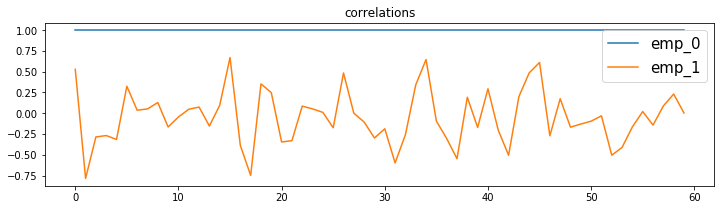

In [40]:
# plot empirical correlations
print(np.shape(covariances_emp_train))
corr_emp = np.zeros_like(covariances_emp_train)

# compute the empirical correlations from the empirical covariances in a smart numpy way
for i in range(np.shape(covariances_emp_train)[-1]):
    for j in range(np.shape(covariances_emp_train)[-1]):
        corr_emp[:, i, j] = covariances_emp_train[:,i,j] / (np.sqrt(covariances_emp_train[:,i,i]) * np.sqrt(covariances_emp_train[:,j,j]))

        
# plot the results and compare with above
corr_emp_0 = corr_emp[:,0,0]
corr_emp_1 = corr_emp[:,0,1]
#corr_emp_2 = corr_emp[:,0,2]
#corr_emp_3 = corr_emp[:,0,3]

plt.figure(figsize=(12, 3))
legend_size = 15

plt.plot(corr_emp_0, label="emp_0")
plt.plot(corr_emp_1, label="emp_1")
#plt.plot(corr_emp_2, label="emp_2")
#plt.plot(corr_emp_3, label="emp_3")
plt.title("correlations")

plt.legend(prop={'size': legend_size});
plt.show();

In [12]:
print(corr_emp_1)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.]


In [13]:
D, T = train_data.shape
print("D: ", D)
print("T: ", T)

D:  2
T:  60


In [14]:
data_centered = train_data - train_data.mean(1).reshape(-1, 1)
emp_cov = 1/T * data_centered @ data_centered.T
print(emp_cov)

[[ 0.00390876 -0.01877852]
 [-0.01877852  1.99196152]]


In [15]:
from model.gwp_mine import GeneralizedWishartProcess as GWP
from model.kernels_mine import squared_exponential as se
from model.kernels_mine import periodic as pe
from model.kernels_mine import ou 
from model.kernels_mine import linear as li 
from model.kernels_mine import rational_quadratic as rq
import time
%matplotlib inline
np.random.seed(42)

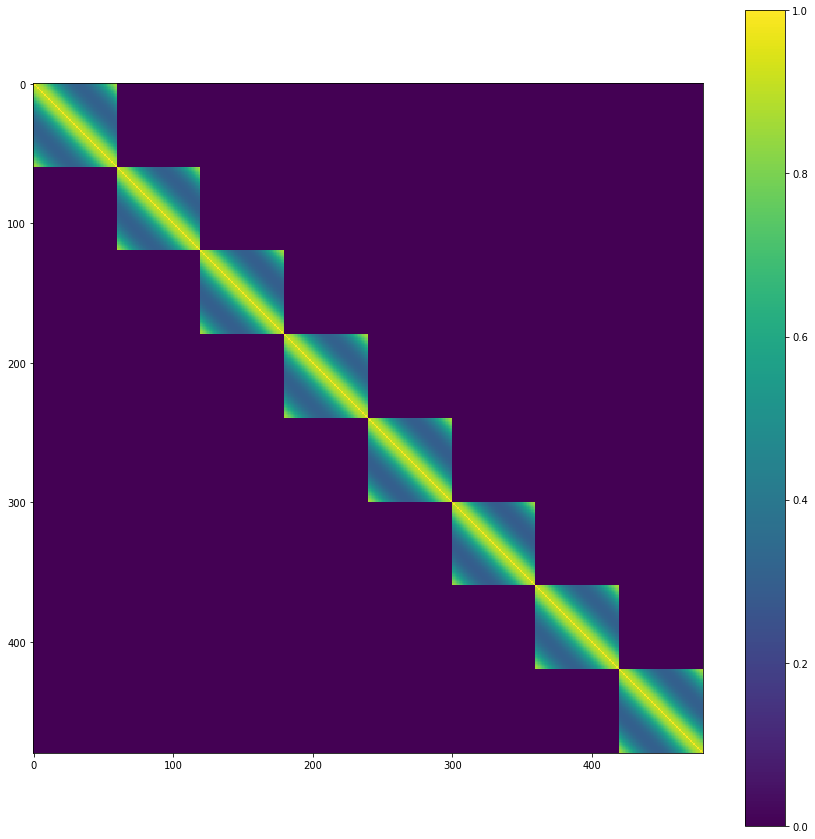

Logtau: (8,); [ 0.08022121  0.26891692  0.24904405  0.22999523  0.10446749 -0.01542963
  0.39797021  0.06661236]
L: (2, 2); [[ 0.16668115  0.        ]
 [-0.12901069  0.58734363]]
Iter 0: loglik = -324182.78, log P(u|...) = -51211.38, log P(tau|...) = -559.17, log P(L|...) = -2475.06
Logtau: (8,); [-0.32549419 -0.22097841 -0.16397919 -0.35875822  0.12355902 -0.49037082
 -0.8285846  -0.6174281 ]
L: (2, 2); [[0.44342305 0.        ]
 [0.01189744 0.20756748]]
Iter 200: loglik = -157.34, log P(u|...) = -156.57, log P(tau|...) = -989.97, log P(L|...) = -157.77
Logtau: (8,); [-0.30861194 -0.38117312 -0.42984259 -0.3427385  -0.27891192 -0.73404735
 -0.71524074 -0.13366361]
L: (2, 2); [[0.44342305 0.        ]
 [0.01189744 0.20756748]]
Iter 400: loglik = -136.05, log P(u|...) = -136.48, log P(tau|...) = -1004.57, log P(L|...) = -137.68
Logtau: (8,); [-0.19716427 -0.73380665 -0.57095851 -0.78573441 -0.58323711 -0.65603243
 -0.4251524   0.47310985]
L: (2, 2); [[0.44342305 0.        ]
 [0.01189744 0

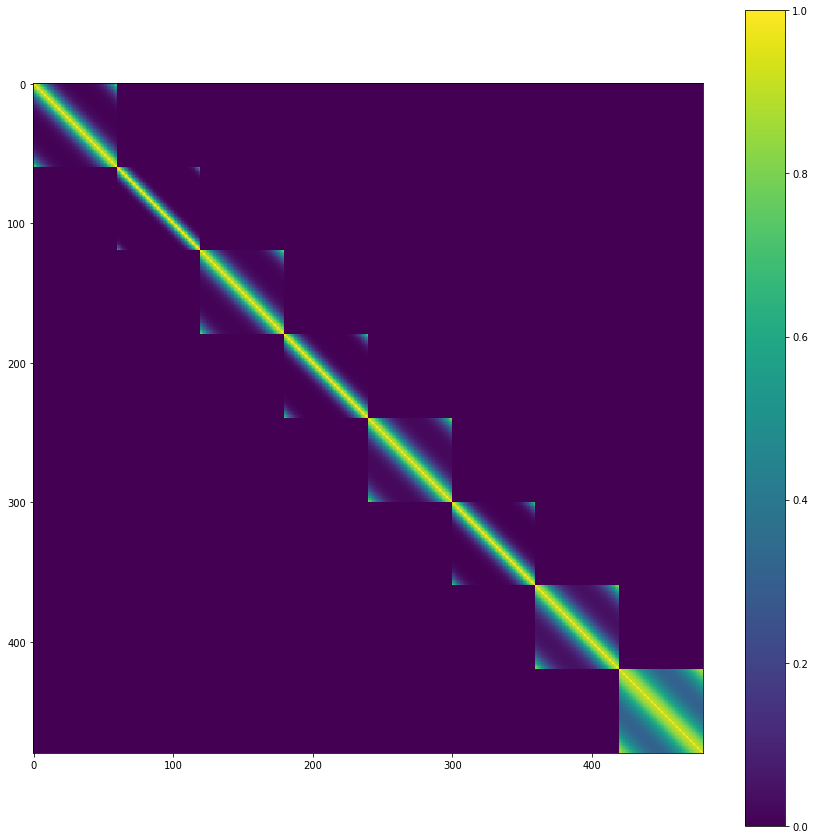

Optimal likelihood: -58.279
time to train: 1232.11


In [16]:
#  sig_var, kernel, tau_prior_mean, tau_prior_var, L_prior_var

# somewhat working: 1, 1, 0.1, 0.01
t0 = time.time()
#gwp = GWP(0.01, ou, 1, 0.01, 1) #se
gwp = GWP(0.95, pe, 0.3, 0.01, 0.1, use_sum_kernel=False, kernel2=ou, sig_var2=0.9, 
                 tau_prior_mean2=1, tau_prior_var2=1, add_ind_mean=True) #se
samples, diagnostics = gwp.fit(train_data, numit=2000, progress=200, sample_tau=True, sample_L=True, add_ind_mean=True)
#samples, train_post_cov_samples = gwp.draw_samples_prior(train_data, verbose=False, add_ind_mean=True)
t1 = time.time()
print("time to train: {:.02f}".format(t1-t0))

(2000, 4)


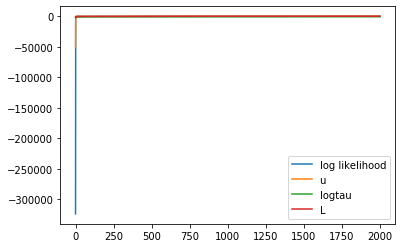

In [17]:
# data_lik, u_prob, logtau_prob, L_prob
#"""
print(np.shape(diagnostics))
diagnostics = np.array(diagnostics)
plt.plot(diagnostics[:,0], label='log likelihood')
plt.plot(diagnostics[:,1], label='u')
plt.plot(diagnostics[:,2], label='logtau')
plt.plot(diagnostics[:,3], label='L')
plt.legend()
plt.show();
#"""

In [18]:
train_post_cov_samples = gwp.draw_train_samples(num_samples=100, c=10)

#rescale to compare with true covariance
#train_post_cov_samples *= 1/train_post_cov_samples.std()
print(np.shape(train_post_cov_samples))

(100, 60, 2, 2)


In [19]:
samples_opt = gwp.optimal_params(burnin=50)

#print(samples_opt)

In [20]:
print(np.shape(samples))
#print(samples[0])
# u, np.exp(logtau), L
print(np.shape(samples[0][0]))
print(np.shape(samples[0][1]))
print(np.shape(samples[0][2]))

(2001, 3)
(480,)
(8,)
(2, 2)


In [21]:
i_=1

u_vector = samples[-i_][0]
L_matrix = samples[-i_][2]

print("estimated V: ", L_matrix  @ L_matrix.T)
print("true V: ", emp_cov)

print(np.shape(u_vector))

estimated V:  [[0.06570102 0.03272882]
 [0.03272882 0.03081698]]
true V:  [[ 0.00390876 -0.01877852]
 [-0.01877852  1.99196152]]
(480,)


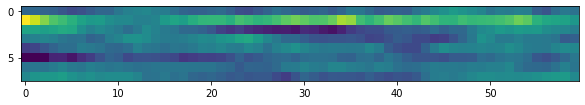

(60, 2, 2)


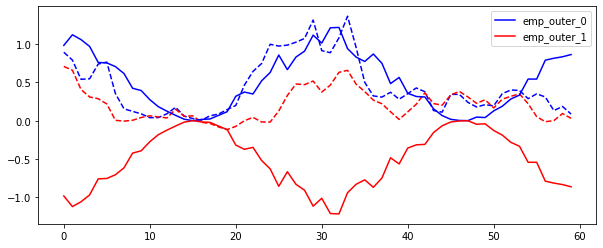

In [22]:


plt.figure(figsize=(10,10))
plt.imshow(u_vector.reshape(8, N_train))
plt.show();

D = 2
Nu = 4

def compute_sigma(L, u):
    """
    Compute the covariance matrix for a specific timepoint.

    L: The lower cholesky decomposition of the scale parameter for the
       Wishart distribution (of dimension N x N).
    u: The fitted GP function values that generate the draw from the Wishart
       distribution, of size Nu * N.
    We assume u to be given in the form [u_11, u_12, ..., u_nu,d]

    Returns the D x D covariance matrix.
    """
    #print(u)
    Sig = np.zeros_like(L)
    for nu in range(Nu):
        idx_ = nu * D
        #print(np.shape(L))
        #print(np.shape(u[idx_:(idx_+D)]))
        Sig += np.outer((L @ u[idx_:(idx_+D)]), (u[idx_:(idx_+D)] @ L.T))

    return Sig

u_vector = u_vector.reshape(8, N_train)
Sigma_inner=[]
for t in range(N_train):
    #u_current = u_[t] #go through row by row
    u_current = u_vector[:, t] #go through row by row
    assert(len(u_current) == Nu * D)
    Sigma_ = compute_sigma(L_matrix, u_current)
    Sigma_inner.append(Sigma_)

Sigma_inner = np.array(Sigma_inner)
print(np.shape(Sigma_inner))

plt.figure(figsize=(10,4))
plt.plot(Sigma_inner[:,0,0], '--', color='blue')
plt.plot(Sigma_inner[:,0,1], '--', color='red')
plt.plot(cov_emp_outer_0, label="emp_outer_0", color='blue')
plt.plot(cov_emp_outer_1, label="emp_outer_1", color='red')
plt.legend()
plt.show();

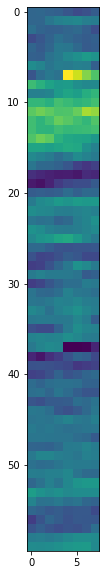

(60, 2, 2)


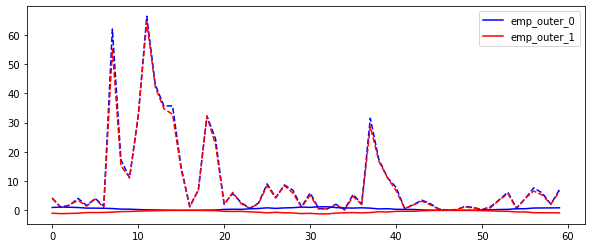

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(u_vector.reshape(N_train, 8))
plt.show();

u_vector = u_vector.reshape(N_train, 8)
Sigma_inner=[]
for t in range(N_train):
    u_current = u_vector[t] #go through row by row
    #u_current = u_vector[:, t] #go through row by row
    assert(len(u_current) == Nu * D)
    Sigma_ = compute_sigma(L_matrix, u_current)
    Sigma_inner.append(Sigma_)

Sigma_inner = np.array(Sigma_inner)
print(np.shape(Sigma_inner))

plt.figure(figsize=(10,4))
plt.plot(Sigma_inner[:,0,0], '--', color='blue')
plt.plot(Sigma_inner[:,0,1], '--', color='red')
plt.plot(cov_emp_outer_0, label="emp_outer_0", color='blue')
plt.plot(cov_emp_outer_1, label="emp_outer_1", color='red')
plt.legend()
plt.show();

In [24]:
# actually compute the covariance matrices as presented in equation (12) in the GWP paper

#u_vector = samples[-1][0]
#L_matrix = samples[-1][2]
u_vector = samples_opt[0]
L_matrix = samples_opt[2]
print(np.shape(u_vector))
print(np.shape(L_matrix))

# Sigma(t) = sum_i^nu L u_i(t) u_i(t)^T L^T  ~ W(V, nu)

u_vector = u_vector.reshape(N_train, -1, np.shape(L_matrix)[0])

cov_matrices_sample = []
for u_t in u_vector:
    cov_prelim = []
    for u_i in u_t:
        #print(np.shape(u_i))
        c_ = np.outer((L_matrix @ u_i), (u_i @ L_matrix.T))
        #print("c_: ", np.shape(c_))
        cov_prelim.append(c_)
    cov_matrices_sample.append(np.sum(np.array(cov_prelim), axis=0))
    
    #invert because it's supposed to be an Inverse Wishart Process???
    #TODO: cholesky decomposition
    #C = np.linalg.inv(np.sum(np.array(cov_prelim), axis=0))
    #cov_matrices_sample.append(C)
    
print(np.shape(cov_matrices_sample))

(480,)
(2, 2)
(60, 2, 2)


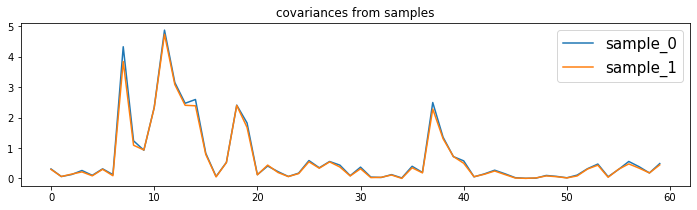

In [25]:
# plot the resulting covariances and correlations
cov_matrices_sample = np.array(cov_matrices_sample)
#rescale for comparison
cov_matrices_sample /= cov_matrices_sample.std()

cov_sample_0 = cov_matrices_sample[:,0,0]
cov_sample_1 = cov_matrices_sample[:,0,1]
#cov_sample_2 = cov_matrices_sample[:,0,2]
#cov_sample_3 = cov_matrices_sample[:,0,3]

plt.figure(figsize=(12, 3))
legend_size = 15

plt.plot(cov_sample_0, label="sample_0")
plt.plot(cov_sample_1, label="sample_1")
#plt.plot(cov_sample_2, label="sample_2")
#plt.plot(cov_sample_3, label="sample_3")
plt.title("covariances from samples")

plt.legend(prop={'size': legend_size});
plt.show();

(60, 2, 2)


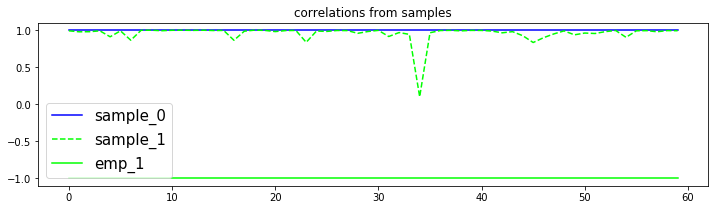

In [26]:
# plot correlations from sample

# plot sample correlations
print(np.shape(cov_matrices_sample))
corr_sample = np.zeros_like(cov_matrices_sample)

# compute the empirical correlations from the empirical covariances in a smart numpy way
for i in range(np.shape(cov_matrices_sample)[-1]):
    for j in range(np.shape(cov_matrices_sample)[-1]):
        corr_sample[:, i, j] = cov_matrices_sample[:,i,j] / (np.sqrt(cov_matrices_sample[:,i,i]) * np.sqrt(cov_matrices_sample[:,j,j]))
        

# plot the results and compare with above
corr_sample_0 = corr_sample[:,0,0]
corr_sample_1 = corr_sample[:,0,1]
#corr_sample_2 = corr_sample[:,0,2]
#corr_sample_3 = corr_sample[:,0,3]

plt.figure(figsize=(12, 3))
legend_size = 15

plt.plot(corr_sample_0,  label="sample_0", color='blue')
plt.plot(corr_sample_1, '--', label="sample_1", color='lime')
#plt.plot(corr_sample_2, '--', label="sample_2", color='yellow')
#plt.plot(corr_sample_3, '--', label="sample_3", color='red')
plt.plot(corr_emp_1, label="emp_1", color='lime')
#plt.plot(corr_emp_2, label="emp_2", color='yellow')
#plt.plot(corr_emp_3, label="emp_3", color='red')
plt.title("correlations from samples")

plt.legend(prop={'size': legend_size});
plt.show();

In [27]:
# redo the same thing for the latest 100 samples

num_samples = 100
c = 10 # take every c-th element only to prevent autocorrelations

samples_test = np.array(samples)
"""
u_vector_samples = samples_test[-num_samples*c::c , 0]
L_matrix_samples = samples_test[-num_samples*c::c , 2]
print(np.shape(u_vector_samples))
print(np.shape(L_matrix_samples))

# Sigma(t) = sum_i^nu L u_i(t) u_i(t)^T L^T  ~ W(V, nu)

u_vector_samples = np.concatenate(u_vector_samples)
u_vector_samples = u_vector_samples.reshape(num_samples, N_train, -1, np.shape(L_matrix)[0])

cov_matrices_samples = []

for i in range(num_samples):
    u_vector = u_vector_samples[i]
    L_matrix = L_matrix_samples[i]
    cov_matrices_s = []
    for u_t in u_vector:
        cov_prelim = []
        for u_i in u_t:
            #print(np.shape(u_i))
            c_ = np.outer((L_matrix @ u_i), (u_i @ L_matrix.T))
            #c_2 = np.matmul(L_matrix, np.matmul(
            #    np.outer(u_i, u_i),
            #    L_matrix.T
            #))
            #assert(np.allclose(c_, c_2))
            #print("c_: ", np.shape(c_))
            cov_prelim.append(c_)
        cov_matrices_s.append(np.sum(np.array(cov_prelim), axis=0))
        
        #invert because it's supposed to be an Inverse Wishart Process???
        #TODO: cholesky decomposition
        #C = np.linalg.inv(np.sum(np.array(cov_prelim), axis=0))
        #cov_matrices_s.append(C)

    #print(np.shape(cov_matrices_s))
    cov_matrices_samples.append(np.array(cov_matrices_s))
    
print(np.shape(cov_matrices_samples))
"""

'\nu_vector_samples = samples_test[-num_samples*c::c , 0]\nL_matrix_samples = samples_test[-num_samples*c::c , 2]\nprint(np.shape(u_vector_samples))\nprint(np.shape(L_matrix_samples))\n\n# Sigma(t) = sum_i^nu L u_i(t) u_i(t)^T L^T  ~ W(V, nu)\n\nu_vector_samples = np.concatenate(u_vector_samples)\nu_vector_samples = u_vector_samples.reshape(num_samples, N_train, -1, np.shape(L_matrix)[0])\n\ncov_matrices_samples = []\n\nfor i in range(num_samples):\n    u_vector = u_vector_samples[i]\n    L_matrix = L_matrix_samples[i]\n    cov_matrices_s = []\n    for u_t in u_vector:\n        cov_prelim = []\n        for u_i in u_t:\n            #print(np.shape(u_i))\n            c_ = np.outer((L_matrix @ u_i), (u_i @ L_matrix.T))\n            #c_2 = np.matmul(L_matrix, np.matmul(\n            #    np.outer(u_i, u_i),\n            #    L_matrix.T\n            #))\n            #assert(np.allclose(c_, c_2))\n            #print("c_: ", np.shape(c_))\n            cov_prelim.append(c_)\n        cov_matric

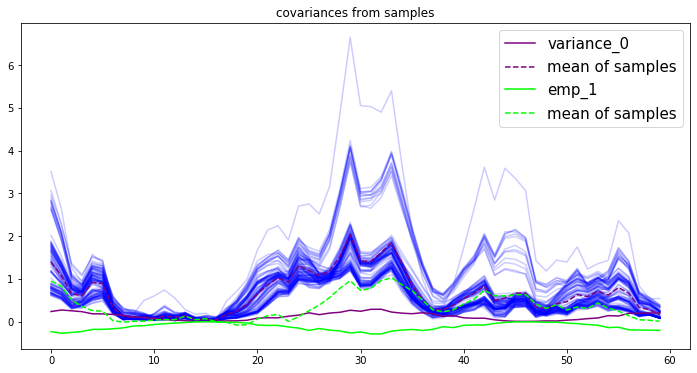

In [28]:
# plot the covariances of all samples 

# plot the resulting covariances and correlations
#cov_matrices_samples = np.array(cov_matrices_samples)

#cov_samples_0 = cov_matrices_samples[:,:,0,0]
#cov_samples_1 = cov_matrices_samples[:,:,0,1]
#cov_samples_2 = cov_matrices_samples[:,:,0,2]
#cov_samples_3 = cov_matrices_samples[:,:,0,3]
num_samples=100

#use other sampling method
cov_samples_0 = train_post_cov_samples[:,:,0,0]
cov_samples_1 = train_post_cov_samples[:,:,0,1]
#cov_samples_2 = train_post_cov_samples[:,:,0,2]
#cov_samples_3 = train_post_cov_samples[:,:,0,3]

cov_samples_0_mean = np.mean(cov_samples_0, 0)
cov_samples_1_mean = np.mean(cov_samples_1, 0)
#cov_samples_2_mean = np.mean(cov_samples_2, 0)
#cov_samples_3_mean = np.mean(cov_samples_3, 0)

plt.figure(figsize=(12, 6))
legend_size = 15

for i in range(num_samples):
    plt.plot(cov_samples_0[i], color='blue', alpha=0.2)#, label="sample_0")
    #plt.plot(cov_samples_1[i], color='blue', alpha=0.2)#, label="sample_1")
    #plt.plot(cov_samples_2[i], color='blue', alpha=0.2)#, label="sample_2")
    #plt.plot(cov_samples_3[i], color ='blue', alpha=0.2)#, label="sample_3")

plt.title("covariances from samples")

#plot empirical
plt.plot(cov_emp_0, color ='purple', alpha=1, label="variance_0")
plt.plot(cov_samples_0_mean, '--', color ='purple', alpha=1, label="mean of samples")
plt.plot(cov_emp_1, color ='lime', alpha=1, label="emp_1")
plt.plot(cov_samples_1_mean, '--', color ='lime', alpha=1, label="mean of samples")
#plt.plot(cov_emp_2, color ='yellow', alpha=1, label="emp_2")
#plt.plot(cov_samples_2_mean, '--',  color ='yellow', alpha=1, label="mean of samples")
#plt.plot(cov_emp_3, color ='red', alpha=1, label="emp_3")
#plt.plot(cov_samples_3_mean, '--', color ='red', alpha=1, label="mean of samples")

plt.legend(prop={'size': legend_size});
plt.show();

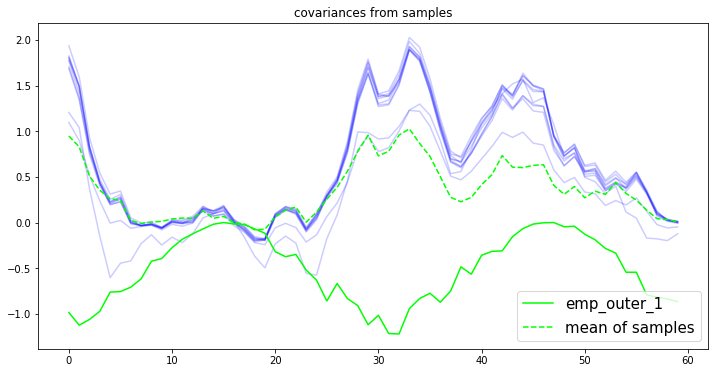

In [29]:
# plot the empirical covariances from the outer product of the data

plt.figure(figsize=(12, 6))
legend_size = 15

for i in range(10):
    #plt.plot(cov_samples_0[i])#, label="sample_0")
    plt.plot(cov_samples_1[i], color='blue', alpha=0.2)#, label="sample_1")
    #plt.plot(cov_samples_2[i], color='blue', alpha=0.2)#, label="sample_2")
    #plt.plot(cov_samples_3[i], color ='blue', alpha=0.2)#, label="sample_3")

plt.title("covariances from samples")

#plot empirical
plt.plot(cov_emp_outer_1, color ='lime', alpha=1, label="emp_outer_1")
plt.plot(cov_samples_1_mean, '--', color ='lime', alpha=1, label="mean of samples")
#plt.plot(cov_emp_outer_2, color ='yellow', alpha=1, label="emp_2_outer")
#plt.plot(cov_samples_2_mean, '--',  color ='yellow', alpha=1, label="mean of samples")
#plt.plot(cov_emp_outer_3, color ='red', alpha=1, label="emp_3_outer")
#plt.plot(cov_samples_3_mean, '--', color ='red', alpha=1, label="mean of samples")

plt.legend(prop={'size': legend_size});
plt.show();

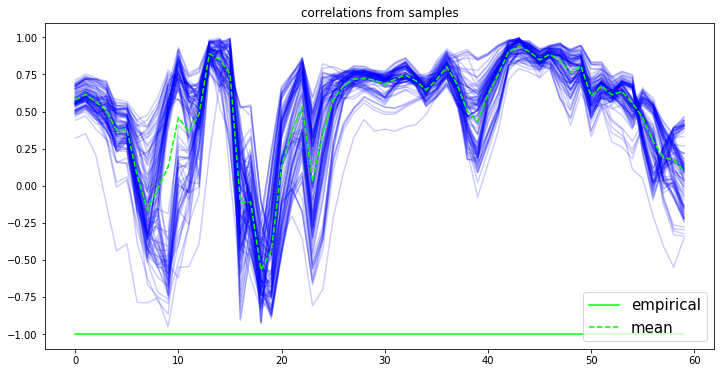

In [30]:
# plot correlations from samples

# plot sample correlations
#print(np.shape(cov_matrices_samples))
#corr_samples = np.zeros_like(cov_matrices_samples)
#print(np.shape(corr_samples))

# compute the empirical correlations from the empirical covariances in a smart numpy way
#for i in range(np.shape(cov_matrices_samples)[-1]):
#    for j in range(np.shape(cov_matrices_samples)[-1]):
#        corr_samples[:,:,i,j] = cov_matrices_samples[:,:,i,j] / (np.sqrt(cov_matrices_samples[:,:,i,i]) * np.sqrt(cov_matrices_samples[:,:,j,j]))

corr_samples = np.zeros_like(train_post_cov_samples)

#compute correlations from other method to sample covariances
for i in range(np.shape(train_post_cov_samples)[-1]):
    for j in range(np.shape(train_post_cov_samples)[-1]):
        corr_samples[:,:,i,j] = train_post_cov_samples[:,:,i,j] / (np.sqrt(train_post_cov_samples[:,:,i,i]) * np.sqrt(train_post_cov_samples[:,:,j,j]))
        

# plot the results and compare with above
corr_samples_0 = corr_samples[:,:,0,0]
corr_samples_1 = corr_samples[:,:,0,1]
#corr_samples_2 = corr_samples[:,:,0,2]
#corr_samples_3 = corr_samples[:,:,0,3]

corr_samples_1_mean = np.mean(corr_samples_1, 0)
#corr_samples_2_mean = np.mean(corr_samples_2, 0)
#corr_samples_3_mean = np.mean(corr_samples_3, 0)

plt.figure(figsize=(12, 6))
legend_size = 15

for i in range(num_samples):
    #plt.plot(corr_samples_0[i])#, label="sample_0")
    plt.plot(corr_samples_1[i], color ='blue', alpha=0.2)#, label="sample_1")
    #plt.plot(corr_samples_2[i], color ='blue', alpha=0.2)#, label="sample_2")
    #plt.plot(corr_samples_3[i], color ='blue', alpha=0.2)#, label="sample_3")
plt.title("correlations from samples")

# plot mean 

# compare to empirical correlation
plt.plot(corr_emp_1, color='lime', label='empirical')
plt.plot(corr_samples_1_mean, '--', color='lime', label='mean')
#plt.plot(corr_emp_2, color='yellow', label='empirical')
#plt.plot(corr_samples_2_mean, '--', color='yellow', label='mean')
#plt.plot(corr_emp_3, color='red', label='empirical')
#plt.plot(corr_samples_3_mean, '--', color='red', label='mean')

plt.legend(prop={'size': legend_size});
plt.show();

In [31]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

In [32]:
samples_test_autocorr = np.concatenate(samples_test[:,0])
samples_test_autocorr = samples_test_autocorr.reshape(501, 20*50)
print(np.shape(samples_test_autocorr))

ValueError: cannot reshape array of size 960480 into shape (501,1000)

In [ ]:
# compute the autocorrelation for the first dimension of u

auto_corr_10 = autocorr_func_1d(samples_test_autocorr[:10, 0])
auto_corr_100 = autocorr_func_1d(samples_test_autocorr[:100, 0])
auto_corr_200 = autocorr_func_1d(samples_test_autocorr[:200, 0])

fix, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(auto_corr_10)

ax[1].plot(auto_corr_100)

ax[2].plot(auto_corr_200)

plt.show();

In [ ]:
# multi-dimensional
from numpy.fft import fft, ifft, fftshift

def xcorr(x):
    """FFT based autocorrelation function, which is faster than numpy.correlate"""
    # x is supposed to be an array of sequences, of shape (totalelements, length)
    length = np.shape(x)[-1]
    fftx = fft(x - x.mean(1).reshape(-1,1), n=(length*2-1), axis=1)
    ret = ifft(fftx * np.conjugate(fftx), axis=1).real
    ret = fftshift(ret, axes=1)
    return(ret)

In [ ]:
md_auto_corr_test = xcorr(samples_test_autocorr[:100])
print(np.shape(md_auto_corr_test))

plt.plot(md_auto_corr_test.mean(1))